In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np; np.set_printoptions(precision=5,suppress=True)
np.random.seed(0)
from extquadcontrol import dp_infinite, dp_finite, ExtendedQuadratic
import matplotlib.pyplot as plt

from system import FiniteHorizonSystem
from policy import AffinePolicy

In [3]:
# import quandl
# quandl.ApiConfig.api_key = "INSERT KEY HERE"
# aapl_data = quandl.get('EOD/AAPL', start_date='2018-01-01',end_date='2018-09-30')
# prices o= np.array(aapl_data.Open)
# logreturns = np.log(1+np.diff(prices)/prices[:-1])
# mu_appl = np.mean(logreturns)
# sigma_appl = np.std(logreturns)
# mu_appl,sigma_appl

In [4]:
mu_appl, sigma_appl = (0.001310425697314454, 0.01525792783452506)

In [5]:
n = 2
m = 1
K = 1

P_f = np.zeros((n,n))
q_f = np.zeros(n)
r_f = 0
g_T = [ExtendedQuadratic(P_f,q_f,r_f,np.array([[1,0]]),np.array([0]))]


def optimal_execution(gamma_ex, gamma_tr, gamma_imp, mu, sigma, T, N):
    def sample(t,N):
        r = np.random.lognormal(mu,sigma,size=N)
        A = np.zeros((N,K,n,n))
        A[:,0,0,0] = 1
        A[:,0,1,1] = r
        B = np.zeros((N,K,n,m))
        B[:,0,0,0] = -1
        B[:,0,1,0] = -r*gamma_imp
        c = np.zeros((N,K,n))
        Pi = np.array([[1]])
        P = np.array([
            [gamma_ex, 0, 0],
            [0,0,-1],
            [0,-1,gamma_tr]
        ])
        q = np.zeros(n+m)
        r = 0
        g = [[ExtendedQuadratic(P,q,r)] for _ in range(N)]

        return A,B,c,g,Pi
    Vs, Qs, policies = dp_finite(sample, g_T, T, N)
    
    return Vs, Qs, policies, sample

In [6]:
# Simple example

gamma_ex = 0
gamma_tr = 1
gamma_imp = 0
mu = 0
sigma = 0
T = 7
N = 1
Vs, Qs, policies, sample = optimal_execution(gamma_ex, gamma_tr, gamma_imp, mu, sigma, T, N)

In [7]:
policies

[[(array([[0.14286, 0.     ]]), array([0.]))],
 [(array([[0.16667, 0.     ]]), array([0.]))],
 [(array([[0.2, 0. ]]), array([0.]))],
 [(array([[0.25, 0.  ]]), array([0.]))],
 [(array([[0.33333, 0.     ]]), array([0.]))],
 [(array([[0.5, 0. ]]), array([0.]))],
 [(array([[1., 0.]]), array([0.]))]]

In [8]:
Vs[0]

[
 P: [[ 0.14286 -1.     ]
  [-1.       0.     ]]
 q: [0. 0.]
 r: 0.0
 
  F: []
 g: []]

In [9]:
# AAPL example

gamma_ex = 1e-4 # dollars / share squared
gamma_tr = 1e-3 # dollars / share squared
gamma_imp = 1e-6 # dollars / share squared

N = 1000
T = 30

mu = mu_appl
sigma = sigma_appl

Vs, Qs, policies, sample = optimal_execution(gamma_ex, gamma_tr, gamma_imp, mu, sigma, T,N)

In [10]:
policies

[[(array([[ 0.27027, -3.24097]]), array([0.]))],
 [(array([[ 0.27027, -3.49398]]), array([0.]))],
 [(array([[ 0.27027, -3.65539]]), array([0.]))],
 [(array([[ 0.27027, -3.79077]]), array([0.]))],
 [(array([[ 0.27027, -3.80991]]), array([0.]))],
 [(array([[ 0.27027, -3.92047]]), array([0.]))],
 [(array([[ 0.27027, -4.0974 ]]), array([0.]))],
 [(array([[ 0.27027, -4.30619]]), array([0.]))],
 [(array([[ 0.27027, -4.64756]]), array([0.]))],
 [(array([[ 0.27027, -4.63909]]), array([0.]))],
 [(array([[ 0.27027, -4.41792]]), array([0.]))],
 [(array([[ 0.27028, -3.81214]]), array([0.]))],
 [(array([[ 0.27028, -4.34892]]), array([0.]))],
 [(array([[ 0.27028, -4.91356]]), array([0.]))],
 [(array([[ 0.2703 , -4.01291]]), array([0.]))],
 [(array([[ 0.27032, -4.00137]]), array([0.]))],
 [(array([[ 0.27037, -3.3463 ]]), array([0.]))],
 [(array([[ 0.27045, -2.86907]]), array([0.]))],
 [(array([[ 0.2706 , -3.04186]]), array([0.]))],
 [(array([[ 0.2709 , -3.58801]]), array([0.]))],
 [(array([[ 0.27145,

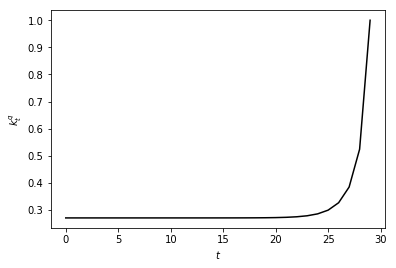

In [11]:
plt.plot([p[0][0][0,0] for p in policies], c='black')
plt.xlabel('$t$')
plt.ylabel('$k_t^q$')
plt.savefig('figs/execution1.pdf')

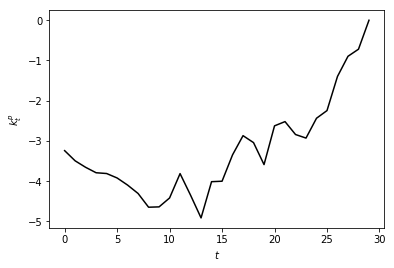

In [12]:
plt.plot([p[0][0][0,1] for p in policies], c='black')
plt.xlabel('$t$')
plt.ylabel('$k_t^p$')
plt.savefig('figs/execution2.pdf')

In [13]:
Vs[0]

[
 P: [[ 0.00037 -1.00324]
  [-1.00324 -0.50216]]
 q: [0. 0.]
 r: 0.0
 
  F: []
 g: []]

In [14]:
system = FiniteHorizonSystem(sample,g_T,K)
policy = AffinePolicy(policies)

In [15]:
Xss = []
totals = []
for _ in range(10):
    Xs, Us, modes, cost = system.simulate(np.array([2000,222]),0,T,policy,0)
    Xss.append(Xs)
    totals.append((np.sum(Xs[:-1,1]*Us[:,0])-np.sum(gamma_tr*Us[:,0])**2))

In [16]:
2000*222

444000

In [17]:
np.mean(totals), np.std(totals)

(475513.15127442835, 41641.70174266246)

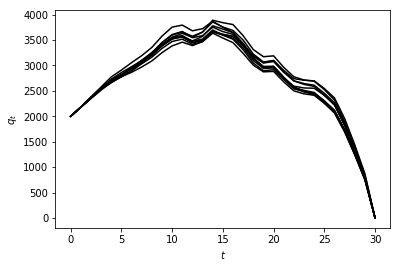

In [18]:
for Xs in Xss:
    plt.plot(np.arange(T+1),Xs[:,0], c='black')
plt.ylabel('$q_t$')
plt.xlabel('$t$')
plt.savefig('figs/execution3.pdf')

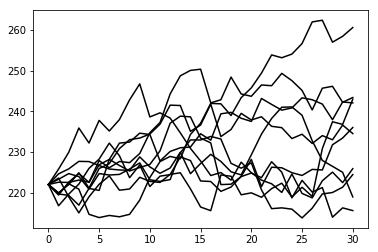

In [19]:
for Xs in Xss:
    plt.plot(np.arange(T+1),Xs[:,1], c='black')